# Setup

In [1]:
import os
import sys
import subprocess
import math
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
import seaborn as sns
import scipy as sp

import anndata as ad
import scanpy as sc

### User variables

In [2]:
RUN_ID = "meqtl_sep23_original_clean"
DATASET_ID = "hca_brain-organoids"

In [3]:
cell_type = str("immature EN")
CT_MAP_JSON_PATH = "config/cell-type_groupings/hca_brain-organoids/original_clean.json"

In [4]:
PROJ_ROOT = "/home/fichtner/projects/footprintQTL"
HCA_BORGS_PROJ = "data/datasets/hca_brain-organoids/"
ATAC_PEAKS_PATH = os.path.join(PROJ_ROOT, "data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peak-matrix_rna-qc-cells_norm-reads-in-tss.h5ad")
RNA_AD_PATH = os.path.join(PROJ_ROOT, "data/datasets/hca_brain-organoids/outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad")

In [5]:
bedtools_bin = '/home/fichtner/.conda/envs/ian/bin/bedtools'

In [6]:
min_cells = 10 # All cts: cell-level | Minimum amount of cells a peak needs to for the peak to be retained (required for functions to work)

n_top_hvps = 10000 # 1 ct: cell-level | Top n ranked peaks to consider in highly-variable-peaks
min_mean_acells = 0.0125
max_mean_acells = 4

min_pval = 0.01 # Min p-value for marker peaks to be considered in the first place in differential peak accessibility
n_top_markers = 10000 # All cts: donor-level (cell agg.) | Top n ranking markers peaks to consider

min_mean_adonors = 0.002
min_donors = 0.24
min_score = 9

### Variables

In [7]:
os.chdir(PROJ_ROOT)

sys.path.append(os.path.join(PROJ_ROOT, "code"))
from helpers.helpers import ct_format, ct_format_alt, create_folder

In [8]:
cell_type_alt = ct_format_alt(cell_type)
cell_type = ct_format(cell_type)

In [9]:
ct_map_id = os.path.basename(CT_MAP_JSON_PATH).split('.')[0]

# Get ct-ann --> grouped-ct mappings
with open(CT_MAP_JSON_PATH, 'r') as f:
    ct_map = json.load(f)

# Format
ct_map_alt = {ct_format_alt(key): [ct_format_alt(e) for e in listt] for key, listt in ct_map.items()}
ct_map_i_alt = {ct_format_alt(old_ct): ct_format_alt(new_ct) for new_ct, old_cts in ct_map.items() for old_ct in old_cts}

ct_map = {ct_format(key): [ct_format(e) for e in listt] for key, listt in ct_map.items()}
ct_map_i = {old_ct: new_ct for new_ct, old_cts in ct_map.items() for old_ct in old_cts}

### Artifact donors

In [10]:
# # TMP
# PROJECT_PATH = '/home/fichtner/projects/footprintQTL'
# DATA_PATH = '/omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/'
# RNA_AD = 'outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad'

# import sys
# sys.path.append(PROJECT_PATH + "/code")
# from helpers.helpers import ct_format, get_anndata_coldata

# cells_coldata = get_anndata_coldata(os.path.join(DATA_PATH, RNA_AD))[0]
# del cells_coldata

In [11]:
# Exclude for some weird reason, samples in QC but not in other files
artifact_donors = {'SAMEA2474458', 'SAMEA2555012'}

# Get data

## Chromatin accessibility cell-level anndata

In [12]:
borgs_tile_mat = ad.read_h5ad(ATAC_PEAKS_PATH)

# Format
borgs_tile_mat.var_names = borgs_tile_mat.var['peak_name']
borgs_tile_mat.obs['cell_type'] = borgs_tile_mat.obs['cell_type'].apply(ct_format)
borgs_tile_mat.obs['cell_type'] = borgs_tile_mat.obs['cell_type'].map(ct_map_i).astype('category')

# Filter cell-types marked 'Discard'
if 'Discard' in borgs_tile_mat.obs['cell_type'].cat.categories:
    borgs_tile_mat = borgs_tile_mat[~(borgs_tile_mat.obs['cell_type'] == 'Discard'), :].copy()
    
    if 'Discard' in borgs_tile_mat.obs['cell_type'].cat.categories:
        borgs_tile_mat.obs['cell_type'] = borgs_tile_mat.obs['cell_type'].cat.remove_categories('Discard')

print(borgs_tile_mat.obs['cell_type'].cat.categories)
borgs_tile_mat

Index(['DL-EN', 'Differentiating-RG', 'Dividing-Glia', 'Glia', 'IPC',
       'Interneurons', 'Interneurons-Prog', 'Midbrain-EN', 'UL-EN',
       'immature-EN'],
      dtype='object')


AnnData object with n_obs × n_vars = 214375 × 736845
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'donor_id', 'clone', 'organoid', 'donor', 'leiden', 'stressed_vs_unstressed_celltypes', 'ReadsInPeaks', 'FRIP', 'barcode', 'batch', 'barcode_batch', 'cell_type'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [13]:
borgs_tile_mat.obs['cell_type']

index_name
CCTAAATCACATAACT-1_sSL0163             UL-EN
GCTGCAATCCTTAGTT-1_sSL0108             UL-EN
AGTCTTGCAGGCGAGT-1_sSL0161     Dividing-Glia
TGACTTAAGTAATCCA-1_sSL0113A              IPC
CAATGTGGTTGAGGTC-1_sSL0149             UL-EN
                                   ...      
TGTTATGAGAAGGTGC-1_sSL0112A            DL-EN
CATTGTAAGTTAGGCT-1_sSL0089              Glia
AGGTCTTAGTTAGTTG-1_sSL0099       immature-EN
CGAGCTGGTCACAAAT-1_sSL0112A            UL-EN
GTTACGTAGATAGACG-1_sSL0093       Midbrain-EN
Name: cell_type, Length: 214375, dtype: category
Categories (10, object): ['DL-EN', 'Differentiating-RG', 'Dividing-Glia', 'Glia', ..., 'Interneurons-Prog', 'Midbrain-EN', 'UL-EN', 'immature-EN']

In [14]:
# Remove artifact donors
donors_qc = ~borgs_tile_mat.obs['donor_id'].isin(artifact_donors)

borgs_tile_mat = borgs_tile_mat[donors_qc, :].copy()

borgs_tile_mat.shape

(210857, 736845)

### Get cell-type anndata

In [15]:
caPeaks_1ct = borgs_tile_mat[borgs_tile_mat.obs['cell_type'] == cell_type, :].copy()
caPeaks_1ct

AnnData object with n_obs × n_vars = 37467 × 736845
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'donor_id', 'clone', 'organoid', 'donor', 'leiden', 'stressed_vs_unstressed_celltypes', 'ReadsInPeaks', 'FRIP', 'barcode', 'batch', 'barcode_batch', 'cell_type'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [16]:
n_peaks_og = caPeaks_1ct.n_vars

In [17]:
caPeaks_1ct.obs['cell_type'].cat.categories

Index(['immature-EN'], dtype='object')

### Hard peak filter: Remove peaks w min cell nr within ct

In [18]:
# Required for HVPeaks
sc.pp.filter_genes(caPeaks_1ct, min_cells=min_cells)
n_cells, n_peaks_post_min_cells = caPeaks_1ct.shape
caPeaks_1ct.shape

(37467, 728783)

In [19]:
n_peaks_min_cells = n_peaks_og - n_peaks_post_min_cells

In [20]:
# Remove hard-filtered peaks from cell-level anndata
borgs_tile_mat = borgs_tile_mat[:, caPeaks_1ct.var_names].copy()

### Cell-type cells level stats

In [21]:
# describe_result = sp.stats.describe(caPeaks_1ct.X.toarray(), axis=0)

# stats = {
#     'nobs': [describe_result.nobs] * len(describe_result.mean),
#     'min': describe_result.minmax[0],
#     'max': describe_result.minmax[1],
#     'mean': describe_result.mean,
#     'variance': describe_result.variance,
#     'skewness': describe_result.skewness,
#     'kurtosis': describe_result.kurtosis
# }

# # Create a DataFrame with the statistics
# df = pd.DataFrame(stats)
# df = df.transpose().reset_index().rename(columns={'index': 'statistic'}).set_index('statistic')

# df

### Init donor-level CA matrix

In [22]:
caPeaks_1ct_agg = sc.get.aggregate(caPeaks_1ct,
                                   by=['donor_id'],
                                   func=['mean'],
                                   axis='obs')

caPeaks_1ct_agg.X = caPeaks_1ct_agg.layers['mean'].copy()
del caPeaks_1ct_agg.layers['mean']

n_donors = caPeaks_1ct_agg.n_obs

caPeaks_1ct_agg

AnnData object with n_obs × n_vars = 59 × 728783
    obs: 'donor_id'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type', 'n_cells'

In [23]:
agg_df = caPeaks_1ct_agg.to_df()
agg_df

peak_name,chr1:804695:805195:501:*:1,chr1:811018:811518:501:*:2,chr1:817077:817577:501:*:3,chr1:817816:818316:501:*:4,chr1:819782:820282:501:*:5,chr1:826617:827117:501:*:6,chr1:827319:827819:501:*:7,chr1:849809:850309:501:*:10,chr1:856826:857326:501:*:11,chr1:858597:859097:501:*:12,...,chrX:155880442:155880942:501:*:19669,chrX:155881013:155881513:501:*:19670,chrX:155881586:155882086:501:*:19671,chrX:155888143:155888643:501:*:19672,chrX:155889305:155889805:501:*:19673,chrX:155891803:155892303:501:*:19674,chrX:155941826:155942326:501:*:19675,chrX:155956608:155957108:501:*:19676,chrX:155959222:155959722:501:*:19677,chrX:155966839:155967339:501:*:19678
SAMEA2420640,0.000000,0.000000,0.001951,0.000000,0.003093,0.005538,0.049195,0.000000,0.000000,0.004151,...,0.000000,0.081641,0.002725,0.000000,0.000000,0.000000,0.000000,0.023339,0.000000,0.000000
SAMEA2445779,0.000643,0.001882,0.000000,0.001100,0.008750,0.001324,0.036607,0.000000,0.000000,0.011147,...,0.002810,0.049344,0.016549,0.014637,0.000000,0.000000,0.002548,0.008806,0.005659,0.002724
SAMEA2445784,0.000000,0.002527,0.000595,0.000000,0.000648,0.002740,0.047624,0.000975,0.000000,0.007177,...,0.009142,0.077807,0.005126,0.000567,0.000000,0.003536,0.005493,0.009304,0.004370,0.016706
SAMEA2459959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMEA2464819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.209215,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMEA2518322,0.000000,0.000000,0.000000,0.000000,0.003167,0.020308,0.057532,0.000000,0.000000,0.021152,...,0.000000,0.056574,0.024372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMEA2518325,0.000000,0.000000,0.004583,0.000000,0.000000,0.003766,0.074167,0.000000,0.000000,0.000000,...,0.007057,0.040957,0.015070,0.035407,0.003224,0.000000,0.000000,0.005283,0.002533,0.000000
SAMEA2518334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMEA2536410,0.000000,0.000899,0.002008,0.000000,0.000510,0.005628,0.041907,0.000602,0.000000,0.002409,...,0.008417,0.076286,0.004770,0.001420,0.000232,0.001374,0.001978,0.004203,0.001850,0.000000
SAMEA2536413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Init ct-donor-level CA matrix

In [24]:
caPeaks_agg_cd = sc.get.aggregate(borgs_tile_mat,
                                   by=['cell_type', 'donor_id'],
                                   func=['mean'],
                                   axis='obs')

caPeaks_agg_cd.X = caPeaks_agg_cd.layers['mean'].copy()
del caPeaks_agg_cd.layers['mean']

caPeaks_agg_cd

AnnData object with n_obs × n_vars = 642 × 728783
    obs: 'cell_type', 'donor_id'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [25]:
# from scipy.sparse import csr_matrix, issparse

# if issparse(caPeaks_agg_cdb.X):
#     print("SCIPY sparse matrix.")
#     if np.any(caPeaks_agg_cdb.X.data < 0):
#         print("There are negative values in the sparse data matrix.")
#     else:
#         print("No negative values in the sparse data matrix.")
# else: 
#     print(f"X type:\n{type(caPeaks_agg_cdb.X)}")
#     if np.any(caPeaks_agg_cdb.X < 0):
#         print("There are negative values in the dense data matrix.")
#     else:
#         print("No negative values in the dense data matrix.")

### Init donor-batch-level CA matrix

In [26]:
# caPeaks_agg_cdb = sc.get.aggregate(borgs_tile_mat,
#                                    by=['cell_type', 'donor_id', 'batch'],
#                                    func=['mean'],
#                                    axis='obs')

# caPeaks_agg_cdb.X = caPeaks_agg_cdb.layers['mean'].copy()
# del caPeaks_agg_cdb.layers['mean']

# n_donor_batch = caPeaks_agg_cdb.obs[caPeaks_agg_cdb.obs['cell_type'] == cell_type].shape[0]

# caPeaks_agg_cdb

In [27]:
# from scipy.sparse import csr_matrix, issparse

# if issparse(caPeaks_agg_cdb.X):
#     print("SCIPY sparse matrix.")
#     if np.any(caPeaks_agg_cdb.X.data < 0):
#         print("There are negative values in the sparse data matrix.")
#     else:
#         print("No negative values in the sparse data matrix.")
# else: 
#     print(f"X type:\n{type(caPeaks_agg_cdb.X)}")
#     if np.any(caPeaks_agg_cdb.X < 0):
#         print("There are negative values in the dense data matrix.")
#     else:
#         print("No negative values in the dense data matrix.")

# Cell-level analysis

## Peak filter: DAPeaks

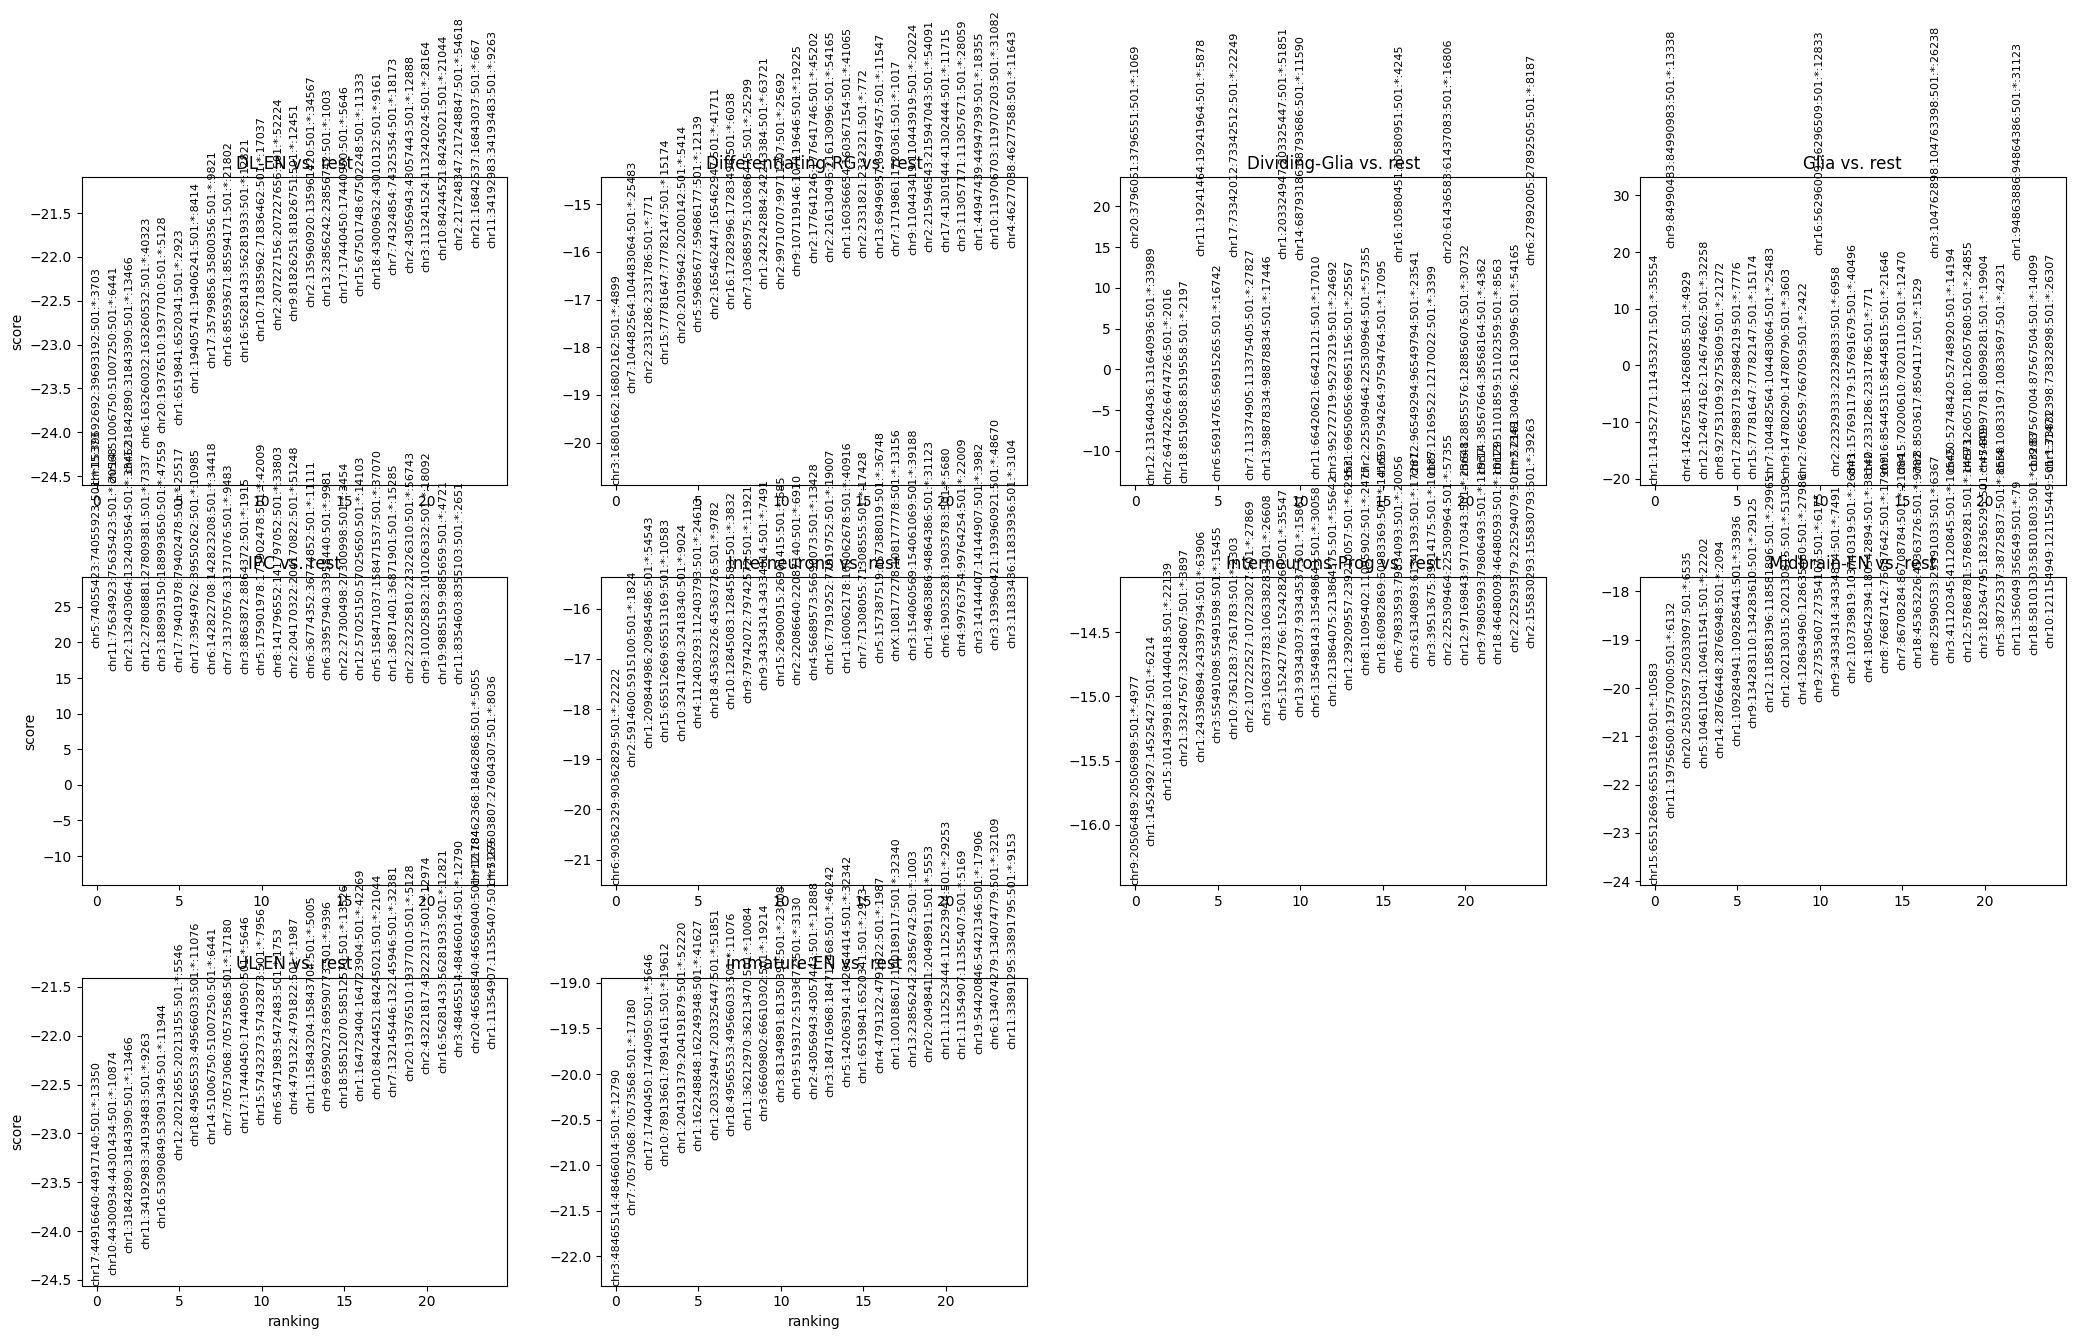

In [28]:
sc.tl.rank_genes_groups(caPeaks_agg_cd, groupby='cell_type', method='t-test', rankby_abs=True)
sc.pl.rank_genes_groups(caPeaks_agg_cd, n_genes=25, sharey=False)

In [29]:
daps = sc.get.rank_genes_groups_df(caPeaks_agg_cd, group=cell_type, pval_cutoff=min_pval)
peaks_markers = set(daps['names'][0:n_top_markers])
daps

,names,scores,logfoldchanges,pvals,pvals_adj
0,chr3:48465514:48466014:501:*:12790,-22.323063,-3.455418,6.927937e-82,5.048963e-76
1,chr7:70573068:70573568:501:*:17180,-21.542208,-3.615941,9.894372e-78,3.605425e-72
2,chr17:17440450:17440950:501:*:5646,-21.051586,-3.581965,5.302137e-75,1.288036e-69
3,chr10:78913661:78914161:501:*:19612,-21.008451,-4.585570,5.274348e-74,9.609638e-69
4,chr1:204191379:204191879:501:*:52220,-20.869635,-4.795411,3.106095e-73,3.772782e-68
...,...,...,...,...,...
209380,chr12:104212509:104213009:501:*:25343,-2.992776,-1.911282,2.872458e-03,9.998196e-03
209381,chr1:205423162:205423662:501:*:52913,-2.992681,-1.379880,2.872159e-03,9.997401e-03
209382,chr1:66208008:66208508:501:*:24608,-2.992679,-2.081068,2.872291e-03,9.997788e-03
209383,chr20:61879258:61879758:501:*:17016,-2.992605,-1.544245,2.872610e-03,9.998617e-03


In [30]:
daps_out_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/differentially-accessible-peaks/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(daps_out_path)))

daps.to_csv(daps_out_path, sep='\t')

In [31]:
del caPeaks_agg_cd

## Peaks filter: intersecting w eQTLs

### Make eQTLs bed file

In [32]:
eqtls = pd.read_csv(os.path.join(HCA_BORGS_PROJ, "eQTL_mapping/eSNPs_significant_all_celltypes_HVGs.tsv"),
                   sep='\t',
                   header=0,
                   index_col=21)
eqtls.columns

Index(['snp_id', 'p_value', 'beta', 'beta_se', 'empirical_feature_p_value',
       'feature_chromosome', 'feature_start', 'feature_end', 'gene_name',
       'n_samples', 'n_e_samples', 'alpha_param', 'beta_param', 'rho',
       'snp_chromosome', 'snp_position', 'assessed_allele', 'call_rate', 'maf',
       'hwe_p', 'feature_id', 'global_corrected_pValue',
       'global_corrected_pValue_BH', 'global_corrected_pValue_BF', 'celltype'],
      dtype='object')

In [33]:
eqtls

,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,gene_name,n_samples,...,snp_position,assessed_allele,call_rate,maf,hwe_p,feature_id,global_corrected_pValue,global_corrected_pValue_BH,global_corrected_pValue_BF,celltype
QTL,,,,,,,,,,,,,,,,,,,,,
ENSG00000269376-chr13_112983450_T_C,chr13_112983450_T_C,0.000066,-0.364427,0.092665,0.000000e+00,13,113009671,113010319,NaN,277,...,112983450,C,1.0,0.044776,1.000000,ENSG00000269376,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000183463-chr13_27824764_C_T,chr13_27824764_C_T,0.047441,-0.089739,0.045430,0.000000e+00,13,27977717,27988693,URAD,277,...,27824764,C,1.0,0.089552,0.073438,ENSG00000183463,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000259182-chr15_101221494_A_C,chr15_101221494_A_C,0.202509,-0.088910,0.069866,0.000000e+00,15,101168530,101170821,NaN,277,...,101221494,A,1.0,0.044776,0.110206,ENSG00000259182,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000286922-chr12_127567286_A_G,chr12_127567286_A_G,0.265404,-0.030918,0.027792,0.000000e+00,12,127486938,127533242,NaN,277,...,127567286,G,1.0,0.074627,1.000000,ENSG00000286922,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000286246-chr12_129375924_C_G,chr12_129375924_C_G,0.949835,-0.000101,0.001608,4.101945e-163,12,129622929,129625366,NaN,277,...,129375924,C,1.0,0.089552,0.073438,ENSG00000286246,1.930191e-161,2.223254e-161,1.111627e-160,immature_EN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000250842-chr5_145190494_A_T,chr5_145190494_A_T,0.000033,0.535958,0.130797,1.828702e-02,5,145337932,145381670,NaN,310,...,145190494,A,1.0,0.316176,1.000000,ENSG00000250842,4.610052e-02,4.610052e-02,1.000000e+00,Differentiating_RG
ENSG00000267537-chr19_28873752_G_A,chr19_28873752_G_A,0.000285,-0.620958,0.172965,1.854836e-02,19,28602379,28648303,NaN,310,...,28873752,G,1.0,0.066176,0.246147,ENSG00000267537,4.669823e-02,4.669823e-02,1.000000e+00,Differentiating_RG
ENSG00000287056-chr6_168100952_C_G,chr6_168100952_C_G,0.001926,-0.216988,0.070509,1.932144e-02,6,168217032,168220262,NaN,310,...,168100952,C,1.0,0.102941,1.000000,ENSG00000287056,4.858106e-02,4.858106e-02,1.000000e+00,Differentiating_RG


In [34]:
eqtls['celltype'].unique()

array(['immature_EN', 'Stressed_Prog', 'IPC', 'Glia', 'UL-EN',
       'Midbrain_EN', 'Dividing_Glia', 'DL-EN', 'Interneurons',
       'Stressed_Neurons', 'Differentiating_RG'], dtype=object)

In [35]:
cell_type_alt

'immature_EN'

In [36]:
# Make eQTL bed file

eqtls_bed = eqtls[['snp_chromosome', 'snp_position', 'beta', 'celltype']].copy()

# Filter out 'Discard' marked cell-types
eqtls_bed = eqtls_bed[eqtls_bed['celltype'].isin(ct_map_alt['Discard'])].copy()

eqtls_bed['start'] = eqtls_bed['snp_position'] - 1 # Make index 0-based open
eqtls_bed['strand'] = '+'
eqtls_bed.reset_index(inplace=True)
eqtls_bed['chr'] = 'chr' + eqtls_bed['snp_chromosome'].astype(str)
eqtls_bed = eqtls_bed.rename(columns={'snp_position': 'end', 'QTL': 'id', 'beta': 'score'})

eqtls_bed = eqtls_bed[['chr', 'start', 'end', 'id', 'score', 'strand']].sort_values(by=['chr', 'start'], ascending=[True, True])
        
eqtls_bed_path = f'data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/eQTLs/{ct_map_id}/eQTLs_{cell_type}.tsv'

create_folder(os.path.dirname(os.path.abspath(eqtls_bed_path)))

eqtls_bed.to_csv(eqtls_bed_path, sep='\t', header=False, index=False)

eqtls_bed

,chr,start,end,id,score,strand
89,chr1,31667956,31667957,ENSG00000203620-chr1_31667957_G_A,-0.362039,+
84,chr1,41152241,41152242,ENSG00000286668-chr1_41152242_C_G,-0.047192,+
83,chr1,41964567,41964568,ENSG00000044012-chr1_41964568_T_A,-0.015555,+
82,chr1,50418557,50418558,ENSG00000284645-chr1_50418558_G_C,-0.030638,+
88,chr1,51296414,51296415,ENSG00000227070-chr1_51296415_A_G,-0.411862,+
...,...,...,...,...,...,...
52,chr4,79528284,79528285,ENSG00000156269-chr4_79528285_AC_A,0.452924,+
20,chr4,89627551,89627552,ENSG00000276542-chr4_89627552_C_T,-0.000616,+
15,chr4,93323765,93323766,ENSG00000250908-chr4_93323766_C_T,-0.131579,+
4,chr4,94676404,94676405,ENSG00000249599-chr4_94676405_C_T,-0.101460,+


### Make peaks bed file

In [37]:
peaks_bed = borgs_tile_mat.var[['chr', 'start', 'end', 'peak_name', 'score']].copy()
peaks_bed['start'] = peaks_bed['start'] - 1
peaks_bed['strand'] = '+'

peaks_bed_path = f'data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/peaks/{ct_map_id}/{cell_type}.bed'

create_folder(os.path.dirname(os.path.abspath(peaks_bed_path)))

peaks_bed.to_csv(peaks_bed_path, sep='\t', header=False, index=False)

print(len(peaks_bed))
peaks_bed

728783


,chr,start,end,peak_name,score,strand
peak_name,,,,,,
chr1:804695:805195:501:*:1,chr1,804694,805195,chr1:804695:805195:501:*:1,3.01127,+
chr1:811018:811518:501:*:2,chr1,811017,811518,chr1:811018:811518:501:*:2,17.72120,+
chr1:817077:817577:501:*:3,chr1,817076,817577,chr1:817077:817577:501:*:3,19.46110,+
chr1:817816:818316:501:*:4,chr1,817815,818316,chr1:817816:818316:501:*:4,10.06330,+
chr1:819782:820282:501:*:5,chr1,819781,820282,chr1:819782:820282:501:*:5,2.71269,+
...,...,...,...,...,...,...
chrX:155891803:155892303:501:*:19674,chrX,155891802,155892303,chrX:155891803:155892303:501:*:19674,11.25430,+
chrX:155941826:155942326:501:*:19675,chrX,155941825,155942326,chrX:155941826:155942326:501:*:19675,9.46511,+
chrX:155956608:155957108:501:*:19676,chrX,155956607,155957108,chrX:155956608:155957108:501:*:19676,42.66500,+


### Peaks intersecting w eQTLs

In [38]:
try:
    result = subprocess.run([bedtools_bin, 'intersect' , '-a', peaks_bed_path, '-b', eqtls_bed_path, '-u'], text=True, capture_output=True)

    # with open(f'data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peaks_{cell_type}_filt-eqtls.bed', 'w') as f:
        # f.write(result.stdout)

    peaks_eqtl = set([i.split('\t')[3] for i in result.stdout.split('\n')[:-1]])
    
except subprocess.CalledProcessError as e:
    
    print(f"Command failed with error: {e.stderr}")

### Peaks filter: close to eGenes

In [39]:
eGenes = set(eqtls.loc[~eqtls['gene_name'].isna(), 'gene_name'].unique())

In [40]:
len(eGenes)

1204

In [41]:
peaks_eGenes = set(borgs_tile_mat.var[borgs_tile_mat.var['nearest_gene'].isin(eGenes)].index)

len(peaks_eGenes)

32688

In [42]:
del borgs_tile_mat

# Cell-type level analysis

### Peak filter: HVPeaks

In [43]:
# Remove batches w with min cell nr
cell_counts_per_donor_batch = caPeaks_1ct.obs.groupby('batch').transform('size')
ca_1ct_batch_filtered = caPeaks_1ct[cell_counts_per_donor_batch >= 10, :].copy()
sum(cell_counts_per_donor_batch >= 10)

37454

/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


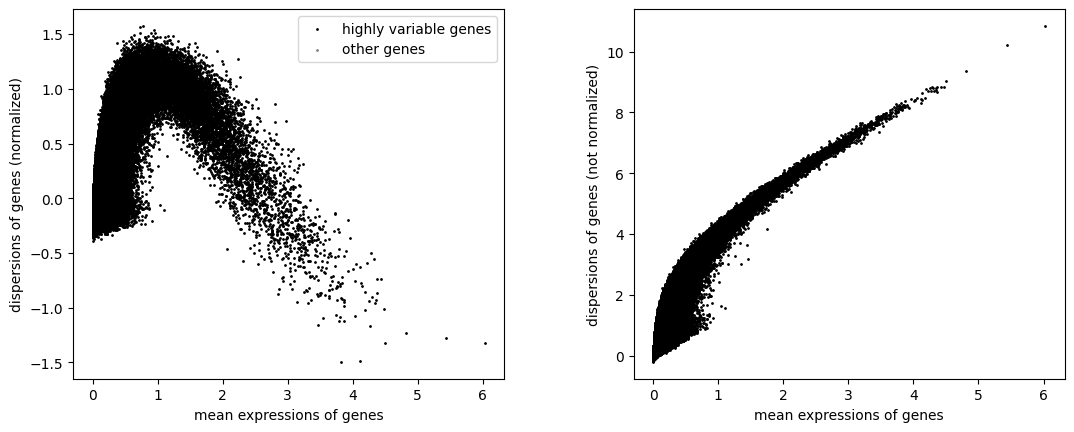

In [44]:
# Seurat (expect log)
sc.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='seurat', batch_key='batch', n_top_genes=ca_1ct_batch_filtered.n_vars)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

In [45]:
# Extract top n HVPs
merge = pd.merge(ca_1ct_batch_filtered.var['means'].to_frame(),
              ca_1ct_batch_filtered.var['highly_variable_nbatches'].to_frame(),
              left_index=True,
              right_index=True,
              how='inner')

merge = pd.merge(merge,
              ca_1ct_batch_filtered.var['dispersions_norm'].abs().to_frame(),
              left_index=True,
              right_index=True,
              how='inner')

merge = merge[(merge['means'] > min_mean_acells) & (merge['means'] < max_mean_acells)]

merge = merge.sort_values(by=['highly_variable_nbatches', 'dispersions_norm'], ascending=[False, False])
peaks_hvp = set(merge[0:n_top_hvps].index)

In [46]:
# peaks_hvp = set(ca_1ct_batch_filtered.var[ca_1ct_batch_filtered.var['highly_variable']].index)

In [47]:
from scipy.sparse import issparse

# Convert sparse matrix to dense format if necessary
data_matrix = caPeaks_1ct.X.toarray() if issparse(caPeaks_1ct.X) else caPeaks_1ct.X

# Check for NaN values
print("Number of NaN values in data:", np.isnan(data_matrix).sum())

# Check for infinite values
print("Number of infinite values in data:", np.isinf(data_matrix).sum())

# Check for rows with all zeros (optimized for sparse matrices)
if issparse(caPeaks_1ct.X):
    zero_rows = np.array((caPeaks_1ct.X != 0).sum(axis=1)).flatten() == 0
else:
    zero_rows = np.sum(data_matrix == 0, axis=1) == data_matrix.shape[1]

print("Number of rows with all zero values:", zero_rows.sum())

Number of NaN values in data: 0


Number of infinite values in data: 0


Number of rows with all zero values: 0


In [48]:
del ca_1ct_batch_filtered

## Peaks filter: min mean across donors

In [49]:
agg_mean = agg_df.mean()

In [50]:
agg_mean.describe()

count    728783.000000
mean          0.007015
std           0.023209
min           0.000048
25%           0.000720
50%           0.001502
75%           0.003942
max           0.912333
dtype: float64

<Axes: title={'center': 'Peak mean across donors distr.'}, ylabel='#'>

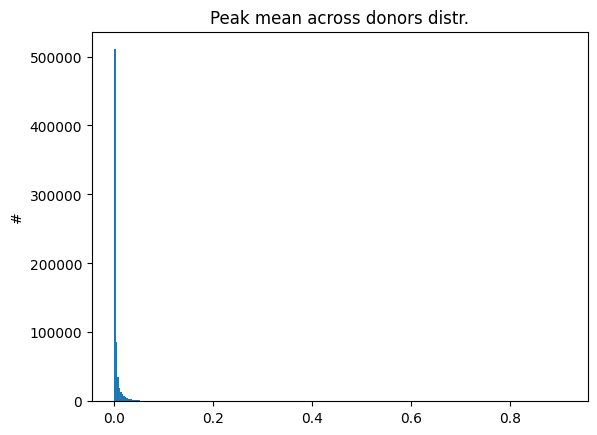

In [51]:
agg_mean.plot(kind='hist',
              bins=300, title="Peak mean across donors distr.",
              xlabel="",
              ylabel="#")

<Axes: title={'center': 'Peak mean across donors ZOOM distr.'}, ylabel='#'>

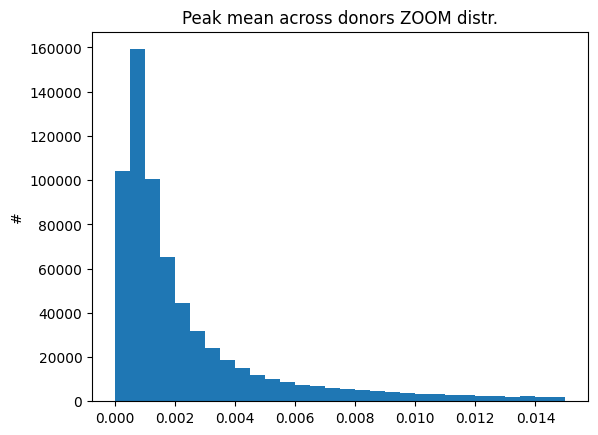

In [52]:
agg_mean.plot(kind='hist', 
              bins=np.linspace(0, 0.015, 31),
              title="Peak mean across donors ZOOM distr.",
              xlabel="",
              ylabel="#")

<Axes: title={'center': 'Peak mean across donors ZOOM distr.'}, ylabel='Density'>

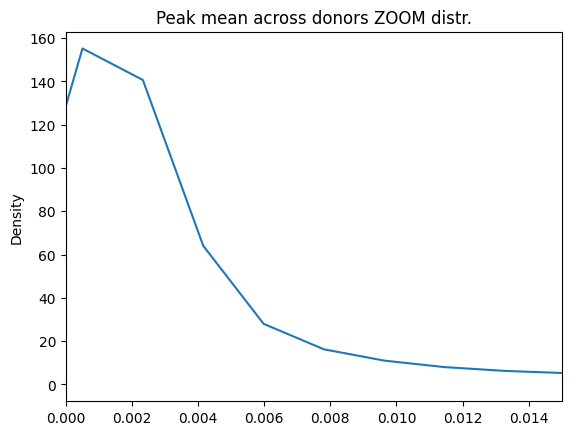

In [53]:
agg_mean.plot(kind='density',
              xlim=[0, 0.015],
              title="Peak mean across donors ZOOM distr.",
              xlabel="")

In [54]:
peaks_min_mean = set(agg_df.loc[:, agg_mean > min_mean_adonors].columns.tolist())

## Peaks filter: min donors with non-zero ca count

In [55]:
non0s = (agg_df != 0).mean()

non0s.describe()

count    728783.000000
mean          0.491136
std           0.186951
min           0.084746
25%           0.338983
50%           0.474576
75%           0.644068
max           0.949153
dtype: float64

<Axes: title={'center': 'Non-zero donor count distr.'}, ylabel='#'>

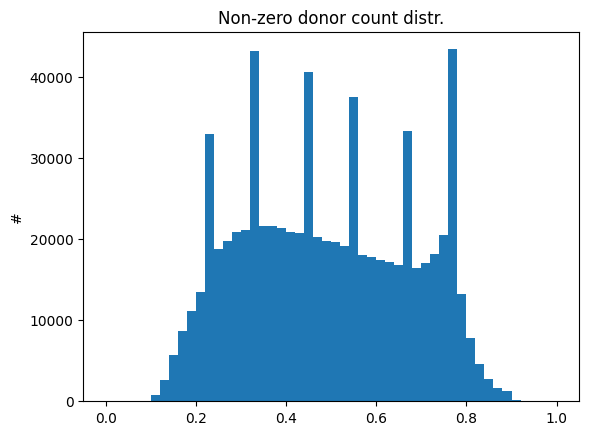

In [56]:
non0s.plot(kind='hist',
           bins=np.linspace(0, 1, 51),
           title="Non-zero donor count distr.",
           ylabel="#")

In [57]:
peaks_min_donors = set(agg_df.loc[:, non0s > min_donors].columns.to_list())

In [58]:
# Density of CA

non0 = np.count_nonzero(caPeaks_1ct_agg.X)
all_ = np.product(caPeaks_1ct_agg.X.shape)
general_ca_density = round(non0 / all_, 2)
print(f'General matrix density: {general_ca_density}')

General matrix density: 0.49


## Peaks filter: min peak score

In [59]:
peak_scores = caPeaks_1ct_agg.var['score']

In [60]:
peak_scores.describe()

count    728783.000000
mean         19.505619
std          28.633040
min           1.028790
25%           5.902470
50%          10.063300
75%          21.281400
max        1017.970000
Name: score, dtype: float64

<Axes: title={'center': 'Peak score distr.'}, ylabel='#'>

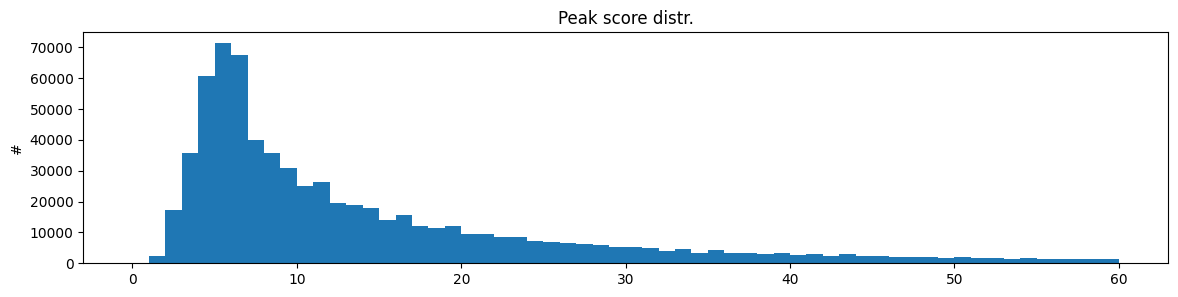

In [61]:
peak_scores.plot(kind='hist',
                 bins=np.linspace(0, 60, 61),
                 figsize=(14,3),
                 title="Peak score distr.",
                 ylabel="#")

In [62]:
peaks_min_score = set(caPeaks_1ct_agg.var[(caPeaks_1ct_agg.var['score'] >= min_score).tolist()].index.tolist())

In [63]:
del agg_df

## CA matrix: final peaks filtering step and export

In [64]:
print(f'Len peaks_hvp = {len(peaks_hvp)}\n' \
      f'peaks_hvp = {list(peaks_hvp)[0:4]}')

print(f'Len peaks_markers = {len(peaks_markers)}\n' \
      f'peaks_markers = {list(peaks_markers)[0:4]}')

print(f'Len peaks_eqtl = {len(peaks_eqtl)}\n' \
      f'peaks_eqtl = {list(peaks_eqtl)[0:4]}')

print(f'Len peaks_eGenes = {len(peaks_eGenes)}\n' \
      f'peaks_eGenes = {list(peaks_eGenes)[0:4]}')

print(f'Len peaks_min_mean = {len(peaks_min_mean)}\n' \
      f'peaks_min_mean = {list(peaks_min_mean)[0:4]}')

print(f'Len peaks_min_donors = {len(peaks_min_donors)}\n' \
      f'peaks_min_donors = {list(peaks_min_donors)[0:4]}')

print(f'Len peaks_min_score = {len(peaks_min_score)}\n' \
      f'peaks_min_score = {list(peaks_min_score)[0:4]}')

Len peaks_hvp = 10000
peaks_hvp = ['chr3:120102604:120103104:501:*:29964', 'chr1:25819662:25820162:501:*:11004', 'chr17:79796901:79797401:501:*:25766', 'chr2:205682140:205682640:501:*:51720']
Len peaks_markers = 10000
peaks_markers = ['chr4:71296926:71297426:501:*:15748', 'chr4:52507712:52508212:501:*:12381', 'chr11:16402999:16403499:501:*:5184', 'chr11:94184356:94184856:501:*:25091']
Len peaks_eqtl = 12
peaks_eqtl = ['chr1:50418091:50418591:501:*:19698', 'chr4:10116632:10117132:501:*:4076', 'chr4:79528192:79528692:501:*:17656', 'chr20:63249125:63249625:501:*:17917']
Len peaks_eGenes = 32688
peaks_eGenes = ['chr4:13670542:13671042:501:*:4785', 'chr11:98389672:98390172:501:*:26094', 'chr4:54091673:54092173:501:*:12806', 'chr1:99670948:99671448:501:*:32240']
Len peaks_min_mean = 299577
peaks_min_mean = ['chr3:145698767:145699267:501:*:37138', 'chr4:25441462:25441962:501:*:7509', 'chr8:2526244:2526744:501:*:677', 'chr8:143612603:143613103:501:*:34773']
Len peaks_min_donors = 653521
peaks_

In [65]:
# Filter final peaks
final_peaks = list((peaks_hvp | peaks_markers | peaks_eqtl | peaks_eGenes) & (peaks_min_mean | peaks_min_donors | peaks_min_score)) # remove peaks_min_mean or peaks_min_donors

caPeaks_1ct_agg = caPeaks_1ct_agg[:, final_peaks].copy()

len(final_peaks)

49848

In [66]:
# Create CA matrix
ca_peaks_out = caPeaks_1ct_agg.to_df().T
ca_peaks_out = ca_peaks_out.rename_axis('peak_id')

In [67]:
len(ca_peaks_out.columns.tolist())

59

In [68]:
ca_donors = list(set(ca_peaks_out.columns.tolist()) - artifact_donors) # Should be redundand
len(ca_donors)

59

In [69]:
ca_peaks_out = ca_peaks_out[ca_donors]

print(ca_peaks_out.shape)
ca_peaks_out

(49848, 59)


,SAMEA2645805,SAMEA3854308,SAMEA2645814,SAMEA3754205,SAMEA2547899,SAMEA3962524,SAMEA2464819,SAMEA3853161,SAMEA4343052,SAMEA3964906,...,SAMEA3851971,SAMEA2678742,SAMEA2682671,SAMEA3974247,SAMEA4451098,SAMEA2445779,SAMEA2698315,SAMEA2658084,SAMEA2536413,SAMEA3962624
peak_id,,,,,,,,,,,,,,,,,,,,,
chr4:13670542:13671042:501:*:4785,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003750,...,0.000223,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.002531,0.0,0.000000
chr11:98389672:98390172:501:*:26094,0.000000,0.000000,0.000000,0.0,0.000000,0.000509,0.000000,0.001184,0.004661,0.001585,...,0.001091,0.000000,0.000000,0.000455,0.001546,0.003934,0.0,0.000000,0.0,0.002785
chr4:52507712:52508212:501:*:12381,0.001396,0.000000,0.000000,0.0,0.001724,0.001136,0.000000,0.000782,0.000652,0.000000,...,0.001434,0.000000,0.000000,0.000815,0.000000,0.000397,0.0,0.000000,0.0,0.001331
chr4:54091673:54092173:501:*:12806,0.030954,0.000000,0.032448,0.0,0.024947,0.030254,0.044608,0.032277,0.039593,0.041722,...,0.036884,0.027189,0.000000,0.036603,0.036584,0.027945,0.0,0.041204,0.0,0.047123
chr3:120102604:120103104:501:*:29964,0.072565,0.000000,0.000000,0.0,0.085796,0.072256,0.230355,0.091248,0.070402,0.075982,...,0.063724,0.068797,0.000000,0.098633,0.083549,0.074724,0.0,0.073629,0.0,0.068210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:77895367:77895867:501:*:10622,0.114933,0.219254,0.201624,0.0,0.160968,0.115965,0.101139,0.128803,0.117582,0.096008,...,0.120808,0.134730,0.139718,0.096024,0.125734,0.106866,0.0,0.186720,0.0,0.136069
chr19:45769266:45769766:501:*:14735,0.051861,0.072105,0.191020,0.0,0.064846,0.074974,0.000000,0.060105,0.078344,0.077763,...,0.068496,0.071210,0.000000,0.047044,0.069291,0.046110,0.0,0.065366,0.0,0.064275
chr19:1592150:1592650:501:*:1044,0.130723,0.275545,0.099034,0.0,0.104218,0.127164,0.047131,0.119367,0.074766,0.134640,...,0.074302,0.096650,0.281114,0.085153,0.102079,0.109768,0.0,0.102957,0.0,0.129278


In [70]:
# Export peak chromatin accessibility
ca_peaks_out_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/peak_ca/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(ca_peaks_out_path)))

ca_peaks_out.round(6).to_csv(ca_peaks_out_path, sep='\t')

### CA matrix stats

In [71]:
_, mean_cells_donor, std_cells_donor, _, _, _, _, _ = caPeaks_1ct.obs.groupby('donor_id').size().describe()

donor_batch = caPeaks_1ct.obs.groupby(['donor_id', 'batch']).size()
donor_batch = donor_batch[donor_batch != 0]
n_donor_batches, mean_cells_donor_batch, std_cells_donor_batch, _, _, _, _, _ = donor_batch.describe()
n_donor_batches = int(n_donor_batches)

In [72]:
# Stats

stats_out_path = f"results/datasets/{DATASET_ID}/matrix-eQTL/{ct_map_id}/io_stats.tsv"

create_folder(os.path.dirname(os.path.abspath(stats_out_path)))

with open(stats_out_path, 'a') as f:
        
    msg = f'\n{RUN_ID}\t' \
            f'{cell_type}\t' \
            f'{general_ca_density}\t' \
            f'{n_cells}\t' \
            f'{n_donors}\t' \
            f'{mean_cells_donor}\t' \
            f'{std_cells_donor}\t' \
            f'{n_donor_batches}\t' \
            f'{mean_cells_donor_batch}\t' \
            f'{std_cells_donor_batch}\t' \
            f'{n_peaks_og}\t' \
            f'{n_peaks_min_cells}\t' \
            f'{n_peaks_post_min_cells}\t' \
            f'{len(peaks_hvp)}\t' \
            f'{len(peaks_markers)}\t' \
            f'{len(peaks_eqtl)}\t' \
            f'{len(peaks_eGenes)}\t' \
            f'{len(peaks_min_mean)}\t' \
            f'{len(peaks_min_donors)}\t' \
            f'{len(peaks_min_score)}\t' \
            f'{ca_peaks_out.shape[0]}\t' \
            f'{ca_peaks_out.shape[1]}'

    f.write(msg)
    print(msg)


meqtl_sep23_original_clean	immature-EN	0.49	37467	59	635.0338983050848	663.0004672100525	235	159.4340425531915	169.2594949003742	736845	8062	728783	10000	10000	12	32688	299577	653521	398053	49848	59


In [73]:
del ca_peaks_out
del caPeaks_1ct

# COV: peak locations

In [74]:
peak_locs = caPeaks_1ct_agg.var[['peak_name', 'chr', 'start', 'end']].copy()
peak_locs['start'] = peak_locs['start'] - 1

peak_locs

,peak_name,chr,start,end
peak_name,,,,
chr4:13670542:13671042:501:*:4785,chr4:13670542:13671042:501:*:4785,chr4,13670541,13671042
chr11:98389672:98390172:501:*:26094,chr11:98389672:98390172:501:*:26094,chr11,98389671,98390172
chr4:52507712:52508212:501:*:12381,chr4:52507712:52508212:501:*:12381,chr4,52507711,52508212
chr4:54091673:54092173:501:*:12806,chr4:54091673:54092173:501:*:12806,chr4,54091672,54092173
chr3:120102604:120103104:501:*:29964,chr3:120102604:120103104:501:*:29964,chr3,120102603,120103104
...,...,...,...,...
chrX:77895367:77895867:501:*:10622,chrX:77895367:77895867:501:*:10622,chrX,77895366,77895867
chr19:45769266:45769766:501:*:14735,chr19:45769266:45769766:501:*:14735,chr19,45769265,45769766
chr19:1592150:1592650:501:*:1044,chr19:1592150:1592650:501:*:1044,chr19,1592149,1592650


In [75]:
peak_locs_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/peak_locations/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(peak_locs_path)))

peak_locs.to_csv(peak_locs_path, sep='\t', index=False)

In [76]:
del peak_locs

# COV: CA PCs

In [77]:
sc.pp.pca(caPeaks_1ct_agg) # Filtered for final peak set

In [78]:
ca_pcs = pd.DataFrame(caPeaks_1ct_agg.obsm['X_pca'][:, 0:20]).set_index(caPeaks_1ct_agg.obs_names)
ca_pcs.columns = [f'caPC_{str(i)}' for i in range(1, 21)]
ca_pcs = ca_pcs.T
ca_pcs = ca_pcs.rename_axis('id')

In [79]:
# ! Important that this doesn't change the sample nr! 2 cells above
ca_pcs = ca_pcs[ca_donors]

print(ca_pcs.shape)
ca_pcs

(20, 59)


,SAMEA2645805,SAMEA3854308,SAMEA2645814,SAMEA3754205,SAMEA2547899,SAMEA3962524,SAMEA2464819,SAMEA3853161,SAMEA4343052,SAMEA3964906,...,SAMEA3851971,SAMEA2678742,SAMEA2682671,SAMEA3974247,SAMEA4451098,SAMEA2445779,SAMEA2698315,SAMEA2658084,SAMEA2536413,SAMEA3962624
id,,,,,,,,,,,,,,,,,,,,,
caPC_1,-2.439618,-2.490067,-2.493468,-2.805374,-2.432130,-2.455035,-2.796058,-2.436957,-2.433912,-2.427447,...,-2.432184,-2.398354,-2.268706,-2.460137,-2.373167,-2.439396,-2.804172,-2.409821,143.849396,-2.427434
caPC_2,-1.420692,-1.459346,-1.624788,-1.515695,-1.411236,-1.417968,-1.307128,-1.412728,-1.386534,-1.428521,...,-1.386182,-1.409892,-1.671915,-1.447607,-1.448388,-1.448027,-1.955393,-1.470978,0.963505,-1.435339
caPC_3,-0.738378,-0.574798,-0.741389,-0.370983,-0.649048,-0.700768,-0.506783,-0.727849,-0.644510,-0.694764,...,-0.605448,-0.747495,-1.094551,-0.662408,-0.659801,-0.723767,-0.593759,-0.759834,0.184125,-0.732368
caPC_4,-0.128216,-0.074575,-0.012114,-0.166366,-0.194194,-0.142464,-0.352997,-0.132672,-0.239851,-0.132855,...,-0.227287,-0.130683,0.106181,-0.086198,-0.200065,-0.161416,36.388817,-0.175576,0.193848,-0.083060
caPC_5,-1.023721,-1.207196,-1.315177,-1.260265,-0.966936,-0.956358,-1.795113,-0.999368,-0.901047,-0.933865,...,-0.928241,-1.053526,-1.502185,-0.859448,-0.899638,-0.950785,23.653427,-0.996106,-0.060063,-0.977632
caPC_6,-0.828978,-0.833382,-0.654792,-0.596355,-0.803331,-0.851176,-1.737700,-0.848596,-0.931261,-0.816405,...,-0.914780,-0.819859,-0.854755,-0.866204,-0.928612,-0.880006,4.148363,-0.890929,-0.150168,-0.759645
caPC_7,-0.641289,-0.560982,-0.903736,-0.604043,-0.605028,-0.608676,-0.785475,-0.652324,-0.626548,-0.610474,...,-0.649892,-0.593927,-0.356015,-0.581793,-0.605620,-0.567881,-0.300906,-0.626951,0.127872,-0.509401
caPC_8,-0.798706,-0.457658,-0.966970,-2.066336,-0.839922,-0.830893,-1.251504,-0.841669,-0.867676,-0.810406,...,-0.938486,-0.902687,-1.162524,-0.857783,-0.867903,-0.871833,1.263487,-0.876677,0.015521,-0.756976
caPC_9,-0.212266,0.095913,-0.334105,-7.782079,-0.295787,-0.281444,24.551176,-0.215606,-0.336058,-0.265129,...,-0.292497,-0.393660,-1.767021,-0.305460,-0.362143,-0.344558,0.381094,-0.332118,0.041910,-0.292738


In [80]:
ca_pcs_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/ca_pcs/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(ca_pcs_path)))

ca_pcs.to_csv(ca_pcs_path, sep='\t')

In [81]:
del ca_pcs
del caPeaks_1ct_agg

# COV: Population structure

In [82]:
gt_pcs = pd.read_csv(os.path.join(HCA_BORGS_PROJ, "Genotypes/GT_PCs.tsv"), sep="\t", index_col=0)
gt_pcs_matrixQTL = gt_pcs.T
gt_pcs_matrixQTL = gt_pcs_matrixQTL.rename_axis('id')
gt_pcs_matrixQTL = gt_pcs_matrixQTL[ca_donors]

print(gt_pcs_matrixQTL.shape)
gt_pcs_matrixQTL

(20, 59)


iid,SAMEA2645805,SAMEA3854308,SAMEA2645814,SAMEA3754205,SAMEA2547899,SAMEA3962524,SAMEA2464819,SAMEA3853161,SAMEA4343052,SAMEA3964906,...,SAMEA3851971,SAMEA2678742,SAMEA2682671,SAMEA3974247,SAMEA4451098,SAMEA2445779,SAMEA2698315,SAMEA2658084,SAMEA2536413,SAMEA3962624
id,,,,,,,,,,,,,,,,,,,,,
PC1,5.062119,15.455708,60.762863,-97.053200,4.767535,12.186271,11.102370,-26.086426,39.326220,-23.225708,...,591.073700,534.269200,16.612453,2.513582,-12.098614,3.230694,-28.362892,-7.199219,37.227420,-39.436108
PC2,17.896296,43.419895,-21.341936,1112.740400,42.741580,42.351612,-18.024128,12.337655,33.001510,13.609195,...,-369.106630,-379.448880,36.950134,42.838642,15.852032,-20.557130,-27.927677,13.413182,29.959509,11.223527
PC3,63.705715,29.958840,40.542133,-396.712070,25.009369,10.103840,9.814706,8.423677,14.530603,46.575330,...,357.076870,-755.075800,-0.269906,20.748500,3.692584,28.402182,1.648885,46.895866,7.322402,7.243265
PC4,7.872817,-21.306501,-49.056087,1003.483340,-16.892120,-94.013070,14.720867,-15.730290,-27.903566,4.890167,...,284.792880,562.314800,24.004366,-6.323660,-5.239960,-6.043996,-32.976494,-19.546944,4.514056,19.611492
PC5,-31.429237,11.136854,9.650810,-89.442830,-39.381832,-3.526762,16.440897,12.673084,21.419876,-3.822149,...,-426.387180,-588.629330,28.637024,-47.334480,4.907794,-36.364742,-31.880617,-9.918574,20.821611,16.133036
PC6,-26.485926,-12.994849,-55.715916,-189.633480,-43.932095,5.925176,37.459100,-49.799580,-17.715687,-56.745644,...,-608.323850,1117.132900,-51.300888,-32.809708,-7.100158,-60.091010,-43.034910,6.438612,-4.850675,-32.406673
PC7,-70.128140,-0.985342,-34.933605,397.612180,11.173185,-43.594402,-9.256178,-11.844399,-18.241447,-22.716658,...,-768.158900,116.265930,-23.499296,-3.031651,58.766727,-45.260980,-18.378374,23.455002,-5.095608,23.316786
PC8,44.648506,-20.355007,13.931620,-362.478730,5.806158,-6.027317,16.599375,18.833464,-22.520147,29.864983,...,0.366550,-23.191648,-45.816135,2.906827,-57.222670,25.995516,36.437107,14.720870,-4.225716,-19.541563
PC9,24.249603,-37.755750,47.833714,-18.213314,56.597780,17.676556,-28.210615,23.225570,33.939266,19.842443,...,72.657005,237.899120,20.013197,-10.186135,0.226498,-5.670022,2.044739,-2.595212,-12.799575,-9.519834


In [83]:
parent_dir = "data/datasets/hca_brain-organoids_processed/covariates/"

if not os.path.isdir(parent_dir):
    os.makedirs(parent_dir)

In [84]:
gt_pcs_matrixQTL_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/genotype/genotype_pcs/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(gt_pcs_matrixQTL_path)))

gt_pcs_matrixQTL.to_csv(gt_pcs_matrixQTL_path, sep='\t')

In [85]:
del gt_pcs
del gt_pcs_matrixQTL

# Genotype

In [86]:
gt = pd.read_csv('data/datasets/hca_brain-organoids_processed/covariates/genotype.tsv', sep='\t', header=0, index_col=0).rename_axis('snp_id')
gt = gt.rename(index=lambda x: 'chr' + str(x))

In [87]:
snps_set = list(set(gt.index))

In [88]:
gt = gt[ca_donors]
gt

,SAMEA2645805,SAMEA3854308,SAMEA2645814,SAMEA3754205,SAMEA2547899,SAMEA3962524,SAMEA2464819,SAMEA3853161,SAMEA4343052,SAMEA3964906,...,SAMEA3851971,SAMEA2678742,SAMEA2682671,SAMEA3974247,SAMEA4451098,SAMEA2445779,SAMEA2698315,SAMEA2658084,SAMEA2536413,SAMEA3962624
snp_id,,,,,,,,,,,,,,,,,,,,,
chr1_89599_A_T,2.0,2.0,0.0,NaN,2.0,0.0,2.0,NaN,NaN,2.0,...,2.0,2.0,0.0,NaN,2.0,2.0,1.0,NaN,2.0,2.0
chr1_94986_C_T,2.0,2.0,2.0,0.0,1.0,2.0,1.0,NaN,NaN,2.0,...,2.0,1.0,2.0,NaN,2.0,1.0,2.0,NaN,2.0,2.0
chr1_94996_A_AT,2.0,2.0,0.0,NaN,2.0,0.0,2.0,NaN,NaN,2.0,...,2.0,2.0,2.0,NaN,2.0,2.0,1.0,NaN,2.0,2.0
chr1_95068_G_A,2.0,2.0,2.0,0.0,1.0,2.0,1.0,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
chr1_96305_C_T,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr22_50780959_T_C,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0
chr22_50781276_G_A,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0
chr22_50783303_T_C,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0


In [89]:
gt_path = f'data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/genotype/{ct_map_id}/genotype_NA_{cell_type}.tsv'

create_folder(os.path.dirname(os.path.abspath(gt_path)))

gt.to_csv(gt_path, sep='\t', na_rep='NaN')

In [90]:
del gt

# SNP locations

In [91]:
snps = pd.read_csv("data/datasets/hca_brain-organoids_processed/covariates/genotype.vcf",
                   sep="\t",
                   comment="#",
                   header=None,
                   names=["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "SAMEA2536416", "SAMEA3854313", "SAMEA3853161", "SAMEA3966392", "SAMEA2625592", "SAMEA2698309", "SAMEA3962624", "SAMEA3965165", "SAMEA2595426", "SAMEA3962389", "SAMEA3973854", "SAMEA3847031", "SAMEA2547622", "SAMEA3854308", "SAMEA3964906", "SAMEA2536410", "SAMEA3735541", "SAMEA2590621", "SAMEA2698315", "SAMEA2445784", "SAMEA3973848", "SAMEA3962524", "SAMEA3485962", "SAMEA2609965", "SAMEA3851971", "SAMEA4089454", "SAMEA2613912", "SAMEA3963885", "SAMEA3963884", "SAMEA2613897", "SAMEA4089453", "SAMEA3851966", "SAMEA3974241", "SAMEA4343052", "SAMEA3962619", "SAMEA3853122", "SAMEA3974015", "SAMEA2518325", "SAMEA2433566", "SAMEA2459959", "SAMEA2675459", "SAMEA2682671", "SAMEA2645805", "SAMEA2711371", "SAMEA2593858", "SAMEA2445790", "SAMEA2518322", "SAMEA2547619", "SAMEA2627577", "SAMEA2547637", "SAMEA3977051", "SAMEA2445779", "SAMEA2609971", "SAMEA3974247", "SAMEA2658107", "SAMEA3754205", "SAMEA2547644", "SAMEA2678742", "SAMEA2474454", "SAMEA2627566", "SAMEA2518334", "SAMEA3967410", "SAMEA2536404", "SAMEA2627578", "SAMEA2518324", "SAMEA3968753", "SAMEA2547899", "SAMEA3754201", "SAMEA2570435", "SAMEA2658084", "SAMEA4451098", "SAMEA2678738", "SAMEA2547633", "SAMEA2609972", "SAMEA2707499", "SAMEA2555017", "SAMEA2420640", "SAMEA4451109", "SAMEA3448738", "SAMEA2627141", "SAMEA3485958", "SAMEA2536413", "SAMEA2464819", "SAMEA2627567", "SAMEA2645814"],
                   index_col=False
                  )

snps = snps[['ID', 'CHROM', 'POS']].rename(columns={'ID': 'snp_id', 'CHROM': 'chr', 'POS': 'pos'})
snps = snps.set_index('snp_id')

In [92]:
snps = snps.loc[snps_set, :].groupby(level=0).first() # There are repeated indexes in snps. Take the first one
snps

,chr,pos
snp_id,,
chr10_100000235_C_T,chr10,100000235
chr10_100000943_G_A,chr10,100000943
chr10_100000979_T_C,chr10,100000979
chr10_100002330_AAAAG_A,chr10,100002330
chr10_100002628_A_C,chr10,100002628
...,...,...
chr9_99997250_C_T,chr9,99997250
chr9_99997408_T_TTTTC,chr9,99997408
chr9_99998141_T_C,chr9,99998141


In [93]:
snps_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/genotype/snp_locations/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(snps_path)))

snps.to_csv(snps_path, sep='\t')

In [94]:
del snps